# Name: Archishman Biswas
# Roll no. 180070009
# EE 679: Computation Assignment 3

The functions required and overall pipeline for GMM-HMM is provided here.
 

# Code for connecting to drive folder (ignore/do not run if not on google colab)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import os 
root_dir = "/content/gdrive/MyDrive/EE 679 Speech Processing Assignments/"
project_folder = "3"

def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')
  os.chdir(root_dir + project_folder)
  
create_and_set_working_directory(project_folder)
! pwd

Mounted at /content/gdrive/
/content/gdrive/MyDrive/EE 679 Speech Processing Assignments/3


# Importing packages that are required in later sections

In [3]:
! pip install hmmlearn
#!cp -r /root/.local/lib/python3.7/site-packages/hmmlearn /usr/local/lib/python3.7/dist-packages/
import hmmlearn
from hmmlearn import hmm 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy.signal as sp
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks

def save_as_wav(y_input,file_name,F_samp):
  y_norm = ((y_input-np.min(y_input))/(np.max(y_input)-np.min(y_input))) - 0.5 #making mean = 0 and swing = 1 
  sf.write(file_name+'.wav',y_norm,F_samp,'PCM_24')

def play_sound(file_name):
  """file_name: the name of the audio file along with the extension"""
  audio = Audio(filename='./'+file_name)
  display(audio) 

# Code for obtaining the MFCC Coefficients

In [4]:
def window_mult_and_padding(input_signal,F_s,t_start,window_type,t_window,N):
  """input_signal: the speech waveform segment input to the system
  window: the windowing function that will be used for STFT analysis, it has support = L points
  window_start_index: the index of the input signal from which the window's starting point will be multiplied
  Output: windowed input signal for sample points [window_start_index,window_start_index+L-1], zero padded to total N points
  Thus final output: x[n]w[n]: [window_start_index,window_start_index+L-1] and zeros: [window_start_index+L,window_start_index+N-1]"""
  
  L = int(t_window*F_s) #support of the window
  window_start_index = int(t_start*F_s) #starting point of the window placement
  
  if window_type == "rectangle":
    window = np.ones(L) #rectangular window function
  else: #by default hamming window is selected(better)  
    window = sp.windows.hamming(L, sym=True) #hamming window function

  windowed_signal = np.zeros(N)
  windowed_signal[0:L] = input_signal[window_start_index:window_start_index+L]*window
   
  return windowed_signal

def calc_feature_vector(in_signal,n_hop,n_window):
  
  in_signal = pre_emphasize(in_signal,0.99); #comment out in case pre-emphasis is not required
  mel_spect = librosa.feature.melspectrogram(y=in_signal,sr=F_s,n_fft=1024,hop_length=n_hop,window="hamming",win_length=n_window)
  mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spect),n_mfcc=13)
  delta1 = np.zeros(mfcc.shape); delta2 = np.zeros(mfcc.shape);
  delta1[:,0] = mfcc[:,0]; delta2[:,0] = mfcc[:,0];
  delta1[:,mfcc.shape[1]-1] = mfcc[:,mfcc.shape[1]-1]; delta2[:,mfcc.shape[1]-1] = mfcc[:,mfcc.shape[1]-1];
  for n in range(1,mfcc.shape[1]-1):
    delta1[:,n] = (mfcc[:,n+1]-mfcc[:,n-1])/2
  for n in range(1,mfcc.shape[1]-1):
    delta2[:,n] = (delta1[:,n+1]-delta1[:,n-1])/2     

  feat_vec = np.concatenate((mfcc,delta1,delta2), axis=0)
  return np.transpose(feat_vec) #each row is a observation and each column a feature

def generating_codebook(feat_vecs,num_centroids,plot_distortions=False):
  """feat_vecs: contains all the 39-length feature vectors(as rows) in for a particular utterance
  num_centroids: choose between 6 to 64, check the distortion for best match
  Returned values: 
  centroids: a num_centroids*39 matrix containing all the estimated centroids from the KMC algorithm
  sd_vec: a 39 length, capturing the original SD value for all of the features, will be helpful in testing part
  """
  from scipy.cluster.vq import vq, kmeans, whiten
  white_feat_vecs = whiten(feat_vecs)

  if plot_distortions:
    distortion = np.zeros(num_centroids)
    for j in range(1,num_centroids+1):
      codebook, distortion_this = kmeans(white_feat_vecs, j)
      distortion[j-1] = distortion_this 
    plt.plot(distortion); plt.show()
  
  codebook, distortion = kmeans(white_feat_vecs, num_centroids)
  sd_vec = np.std(feat_vecs, axis=0) #calculates and returns the sd of each column of data 
  #note that, the whitened matrix, each of the column entries feat_vecs is divided by the sd of same feat_vecs column
  return sd_vec, codebook, distortion #the codebook has the required num_centroids vectors as rows

def normalize_audio(x):
  """The range of output audio will be -1 to 1 for any input given, a DC shift and constant multiplication doesn't changes the utterance"""
  high = np.max(x); low = np.min(x)
  y = (2*x-low-high)/(high-low)
  return y

def end_pointing_using_STE(x,F_s,t_window,th_frac_ste,th_frac_zcr,ZCR=False):
  """x: input signal
  th_frac_ste: threshold for STE, th_frac_zcr: threshold for ZCR
  output: modified version of signal x, s.t. silences are removed"""
  n_per_frame = int(t_window*F_s);
  STE = np.transpose(librosa.feature.rms(x,frame_length=n_per_frame,hop_length=1)); ste_th = th_frac_ste*np.max(STE); 
  speech_present = (STE>ste_th)
  
  if ZCR:
    ZCR = np.transpose(librosa.feature.zero_crossing_rate(x,frame_length=n_per_frame,hop_length=1)); zcr_th = th_frac_zcr*np.max(ZCR);
    speech_present = np.logical_or(STE>ste_th,ZCR>zcr_th)
  speech_present = speech_present[1:,0] #making the size correct, now select out the relevant entries of x
  
  return x[speech_present]    

def pre_emphasize(x,alpha):
  y = librosa.effects.preemphasis(x,coef=alpha)
  
  return y    

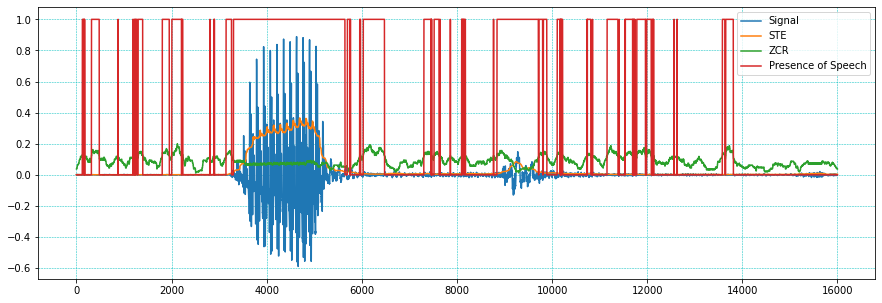

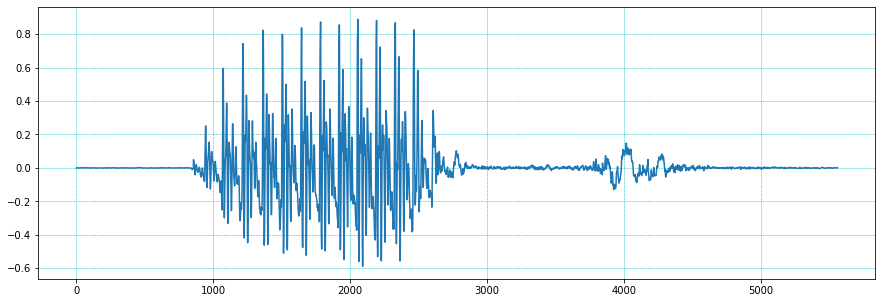

In [5]:
#Listening to the sound wave first
file_name = "sound_10.wav"
x, F_s = sf.read(file_name); #x = normalize_audio(x)
play_sound(file_name)
t = np.arange(0,x.shape[0])/F_s

#testing of preprocessing algorithms
t_window = 10e-3; n_per_frame = int(t_window*F_s);
th_frac_ste = 0.05; th_frac_zcr = 0.6; 
STE = np.transpose(librosa.feature.rms(x,frame_length=n_per_frame,hop_length=1)); ste_th = th_frac_ste*np.max(STE); 
ZCR = np.transpose(librosa.feature.zero_crossing_rate(x,frame_length=n_per_frame,hop_length=1)); zcr_th = th_frac_zcr*np.max(ZCR);

#speech_present = (STE>ste_th)
speech_present = np.logical_or(STE>ste_th,ZCR>zcr_th)

speech_present = speech_present[1:,0]
#plotting signal with RMSE and ZCR
plt.figure(figsize = (15,5))
plt.plot(x,label='Signal'); plt.plot(STE,label='STE'); plt.plot(ZCR,label='ZCR'); plt.plot(speech_present,label='Presence of Speech'); 
plt.grid(color = 'c', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

#showing signal after end-pointing
x_end_point = end_pointing_using_STE(x,F_s,10e-3,0.1,0.6,True)
plt.figure(figsize = (15,5))
plt.plot(x_end_point); 
plt.grid(color = 'c', linestyle = '--', linewidth = 0.5); plt.show()

Audio(data=x_end_point,rate=F_s)

# Reading from files and making feature vectors

In [6]:
permanent_dir = '/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3'
os.chdir(permanent_dir)

train_adress = permanent_dir + "/DATASET" + "/train" 
path = train_adress
train_list = os.listdir(path)
print("Files and directories in '", path, "' :")
print(train_list)

#required order = ['go', 'left', 'down', 'yes', 'stop', 'on', 'off', 'up', 'no', 'right']

Files and directories in ' /content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train ' :
['go', 'left', 'down', 'yes', 'stop', 'on', 'off', 'up', 'no', 'right']


In [ ]:
t_window = 20e-3; n_window = int(t_window*F_s)
t_hop = 10e-3; n_hop = int(t_hop*F_s)

num_train = 2000 #keep it less than the min number of utterances available for any class value
all_words_feats_list = []; lengths_each_sample = [];

for folders in range(len(train_list)):
  feat_vec_this_word = np.zeros((1,39))
  lengths_each_sample_this_word = []
  word_path = path + "/" + train_list[folders] 
  word_list = os.listdir(word_path)
  #print(word_list); 
  print(word_path);
  os.chdir(word_path)
  #num_utterances = len(word_list)
  num_utterances = num_train #using a little less than all training samples
  for files in range(num_utterances):    
    file_name = word_list[files]  
    x,_ = sf.read(file_name); 
    #x = end_pointing_using_STE(x,F_s,10e-3,0.1,0.6,True) #for end-pointing, set the thresholds appropriately, comment out if end-pointing not required
    x = normalize_audio(x); #comment out if normalization is not required
    #print(x.shape)
    feat_this = calc_feature_vector(x,n_hop,n_window)
    lengths_each_sample_this_word.append(feat_this.shape[0]) 
    #print(feat_this.shape)
    feat_vec_this_word = np.concatenate((feat_vec_this_word,feat_this),axis=0)
    #print(file_name); print("******")
    #play_sound(file_name)

  feat_vec_this_word = feat_vec_this_word[1:,:] #to remove the first all zero row 
  print(feat_vec_this_word.shape)
  lengths_each_sample.append(np.array(lengths_each_sample_this_word))
  all_words_feats_list.append(feat_vec_this_word)

#returning back to the original directory
%cd '/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/'    

/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/go
(197934, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/left
(199571, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/down
(199144, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/yes
(199103, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/stop
(199051, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/on
(198335, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/off
(199108, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/up
(197614, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/no
(198367, 39)
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/train/right
(198938, 39)
/content/gdrive/My Drive/EE 679 Speech Processing

In [9]:
#all_words_feats_list = np.load("hmm_feats_list.npy",allow_pickle=True)
#lengths_each_sample = np.load("hmm_feats_lengths.npy",allow_pickle=True)

all_words_feats_list = np.load("hmm_feats_list.npy",allow_pickle=True)
lengths_each_sample = np.load("hmm_feats_lengths.npy",allow_pickle=True)

In [ ]:
feats_list = np.array(all_words_feats_list)
lengths_list = np.array(lengths_each_sample)

np.save("hmm_feats_list.npy", feats_list)
np.save("hmm_feats_lengths.npy", lengths_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


# Train the GMM-HMM models using each of the vectors

In [7]:
all_words_feats_list_noisy = np.load("aug_feats_list.npy",allow_pickle=True)
lengths_each_sample_noisy = np.load("aug_feats_lengths.npy",allow_pickle=True)

all_words_feats_list_clean = np.load("hmm_feats_list.npy",allow_pickle=True)
lengths_each_sample_clean = np.load("hmm_feats_lengths.npy",allow_pickle=True)

In [8]:
#order of words = ['go', 'left', 'down', 'yes', 'stop', 'on', 'off', 'up', 'no', 'right'] ---> stored in train_list 
#vectors in all_words_feats_list are as per the above order
#full_codebook = entries of the list all_words_feats_list 
#shape of each of these full_codebooks = (n_samples, n_features), for our case n_features = 39 always 
#the length of the individual sequences arranged in a matrix form is given by (lengths_each_sample), an array of n_sequences, 
#sum of all entries(there are total n_sequences of them) in (lengths_each_sample) = n_samples 

trained_model = {} # the trained GMM-HMM for each of the words will be stored in a dict, the key being the word itself
hmms = 16; gmms = 12;
batch_size = 2000; num_batches = int(2000/batch_size); 

for word in range(len(train_list)): #this loop will train the GMM-HMM model for a particular word, suppose 'go'
  this_word_model = hmm.GMMHMM(n_components=hmms, n_mix=gmms, covariance_type='diag', n_iter=10, init_params='s' , verbose=False ) #initialize the GMM-HMM to be trained 
  
  #training_X = np.concatenate((all_words_feats_list_noisy[word],all_words_feats_list_clean[word]),axis=0) #choosing all the MFCC vectors for the word(the full_codebook), shape = (n_samples, n_features)
  #lengths_this_word = np.concatenate((lengths_each_sample_noisy[word],lengths_each_sample_clean[word]),axis=0) 

  training_X = all_words_feats_list_noisy[word] #choosing all the MFCC vectors for the word(the full_codebook), shape = (n_samples, n_features)
  lengths_this_word = lengths_each_sample_noisy[word]
  
  #print(training_X.shape)
  print("Training HMM of word ",train_list[word])
  for batch_index in range(num_batches):
    print("Training for batch number: ",batch_index+1)
    
    lengths_this_batch = lengths_this_word[(batch_index*batch_size):((batch_index+1)*batch_size)]
    training_this_batch = training_X[(lengths_this_word[0:(batch_index*batch_size)].sum(axis=0)):(lengths_this_word[0:((batch_index+1)*batch_size)].sum(axis=0)),:]

    print(lengths_this_batch.sum()); print(training_this_batch.shape)
    this_word_model.fit(training_this_batch,lengths=lengths_this_batch) #this trains the GMM-HMM model, the lengths_each_sample is an array of lenghth n_sequences(2000 each in our case)
  
  #print(this_word_model)
  print("Done with HMM of word ",train_list[word])  
  trained_model[train_list[word]] = this_word_model


Training HMM of word  go
Training for batch number:  1
96441
(96441, 39)
Done with HMM of word  go
Training HMM of word  left
Training for batch number:  1
87970
(87970, 39)
Done with HMM of word  left
Training HMM of word  down
Training for batch number:  1
110275
(110275, 39)
Done with HMM of word  down
Training HMM of word  yes
Training for batch number:  1
106825
(106825, 39)
Done with HMM of word  yes
Training HMM of word  stop
Training for batch number:  1
84176
(84176, 39)
Done with HMM of word  stop
Training HMM of word  on
Training for batch number:  1
108993
(108993, 39)
Done with HMM of word  on
Training HMM of word  off
Training for batch number:  1
88041
(88041, 39)
Done with HMM of word  off
Training HMM of word  up
Training for batch number:  1
71383
(71383, 39)
Done with HMM of word  up
Training HMM of word  no
Training for batch number:  1
111429
(111429, 39)
Done with HMM of word  no
Training HMM of word  right
Training for batch number:  1
90721
(90721, 39)
Done with

# Testing using the test audio files on the trained GMM-HMMs

In [9]:
#Code to find the best class given the HMMs

def predict_best_word(test_vec_sequences,HMM_list,train_list):
  """"test_vec: each of the test_vec_sequences is of shape (n_samples x 39) 
  HMM_list: list of length 10 HMMs that are trained on the respective words
  output: vector(length = 10) which has the score calculated for each of the HMMs"""
  
  score = np.zeros(len(HMM_list))
  for hmm_model_index in range(len(HMM_list)):
    hmm_this = HMM_list[train_list[hmm_model_index]] #can be a 16x39 
    #print(test_vec_sequences.shape)
    score[hmm_model_index] = hmm_this.score(test_vec_sequences,lengths=None) 

  return score

In [13]:
test_adress = permanent_dir + "/DATASET" + "/test_noisy" 
path = test_adress
test_list = os.listdir(path)
print("Files and directories in '", path, "' :")
print(test_list)

Files and directories in ' /content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy ' :
['up', 'left', 'no', 'stop', 'yes', 'go', 'off', 'down', 'on', 'right']


In [14]:
t_window = 20e-3; t_hop = 10e-3; 
n_window = int(F_s*t_window); n_hop = int(F_s*t_hop); 

num_test = 240 #keep it less than the min number of utterances available for any class value
y_actual = []; y_pred = []; #this will be used to make the confusion matrices

for folders in range(len(test_list)):
  word_path = path + "/" + test_list[folders] 
  word_list = os.listdir(word_path)
  #print(word_list); 
  print(word_path);
  os.chdir(word_path)
  num_utterances = len(word_list)
  #num_utterances = num_test #using a little less than all test samples
  for files in range(num_utterances):    
    file_name = word_list[files]  
    x,_ = sf.read(file_name); 
    x = end_pointing_using_STE(x,F_s,10e-3,0.1,0.6,True) #for end-pointing, set the thresholds appropriately, comment out if end-pointing not required
    x = normalize_audio(x); #comment out if normalization is not required
    test_vec = calc_feature_vector(x,n_hop,n_window)
    #print(test_vec.shape)
    score = predict_best_word(test_vec,trained_model,train_list)
    arg_max = np.argmax(score)
    #print(train_list[arg_max])

    y_actual.append(test_list[folders]); y_pred.append(train_list[arg_max])

#returning back to the original directory
%cd '/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/'    

/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/up
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/left
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/no
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/stop
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/yes
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/go
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/off
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/down
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/on
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3/DATASET/test_noisy/right
/content/gdrive/My Drive/EE 679 Speech Processing Assignments/3


# Displaying confusion matrix and summary of recognition

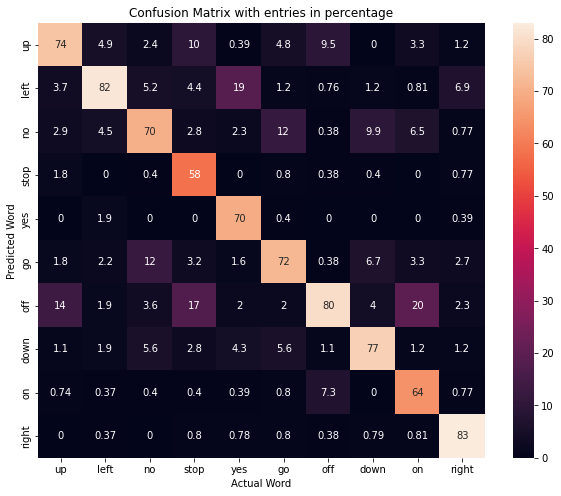

SUMMARY: 
              precision    recall  f1-score   support

          up       0.74      0.68      0.71       295
        left       0.82      0.67      0.73       329
          no       0.70      0.62      0.66       284
        stop       0.58      0.92      0.71       157
         yes       0.70      0.96      0.81       185
          go       0.72      0.67      0.69       267
         off       0.80      0.55      0.65       378
        down       0.77      0.76      0.76       258
          on       0.64      0.84      0.73       187
       right       0.83      0.95      0.88       227

    accuracy                           0.73      2567
   macro avg       0.73      0.76      0.74      2567
weighted avg       0.74      0.73      0.73      2567



In [15]:
from sklearn import metrics
conf_matrix = metrics.confusion_matrix(y_pred, y_actual, labels=test_list)
conf_matrix = 100*conf_matrix/conf_matrix.astype(np.float).sum(axis=0)

import seaborn as sns
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True, xticklabels= test_list,yticklabels= test_list)
plt.title("Confusion Matrix with entries in percentage")
plt.xlabel("Actual Word"); plt.ylabel("Predicted Word"); 
plt.show()

print("SUMMARY: ")
print(metrics.classification_report(y_pred,y_actual,labels=test_list))

#Save the final important matrices such as models and features

In [16]:
import pickle

a_file = open("HMM_16_12_acc_85_73.pkl", "wb")
pickle.dump(trained_model, a_file)
a_file.close()

a_file = open("HMM_16_12_acc_85_73.pkl", "rb")
output = pickle.load(a_file)